## Expanding Category Columns, Dealing with Null

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


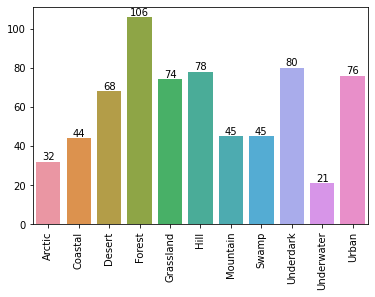

In [ ]:
ax = sns.barplot(Environment_sum.index,Environment_sum.values)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for i in ax.containers:
    ax.bar_label(i,)

### Ancient Red Dragon


## Breaking Up the Dataset

Now that we know the DMG equation does not line up with the Monster Manual CR, that could spell disaster for our players. Let's start working on something a little more robust.

The first step is to dive into the dataset. We have a lot of cleaning to do. There are mis-typed features, features that are lists of traits and abilities, strings that need to be ints, so on and so forth. Let's start but looking at JUST the numerical data

In [ ]:
monster_df.describe()

,Mythic Actions,Armor Class,Hit Points,Proficiency Bonus,STR,DEX,CON,INT,WIS,CHA
count,0.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,NaN,13.985632,78.399425,2.712644,14.951149,12.706897,14.991379,7.683908,11.606322,9.548851
std,NaN,3.155403,96.670352,1.296486,6.705018,3.078279,4.385913,5.673953,2.896418,5.780861
min,NaN,5.000000,1.000000,2.000000,1.000000,1.000000,8.000000,1.000000,3.000000,1.000000
25%,NaN,12.000000,17.000000,2.000000,11.000000,10.000000,12.000000,2.000000,10.000000,5.000000
50%,NaN,13.000000,45.000000,2.000000,16.000000,13.000000,14.000000,7.000000,11.500000,8.000000
75%,NaN,16.000000,110.000000,3.000000,19.000000,15.000000,17.000000,12.000000,13.000000,14.000000
max,NaN,25.000000,676.000000,9.000000,30.000000,22.000000,30.000000,25.000000,25.000000,30.000000


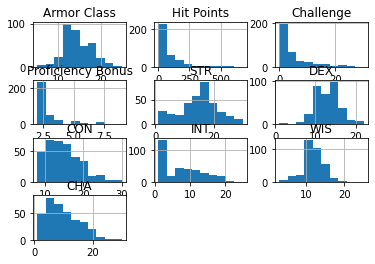

In [ ]:
monster_df.hist();

Based on the Challenege Rating and Hit points, we have a very skewed dataset. That's totally ok! Most campaigns don't go past lvl 15 usually, so it makes sense wizards would have more lower CR monsters. Also, just rationally, a world with just as many high CR monsters sounds scary AF. 

However, I can see Armor class seems to follow a somewhat normal distributions, same with Dex, STR, and WIS. CHA, CON, INT are also very right tail skewed. We expect this from Proficiency bonus since that goes hand in hand with Challenege rating

In [ ]:
#Create a numeric only database

monster_df_numeric = monster_df[['Hit Points', 'Armor Class','Proficiency Bonus', 'STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA', 'Challenge']]

In [ ]:
monster_df_numeric

,Hit Points,Armor Class,Proficiency Bonus,STR,DEX,CON,INT,WIS,CHA,Challenge
Monster Name,,,,,,,,,,
Adult Green Dragon,207,19,5,23,12,21,18,15,17,15.00
Adult Silver Dragon,243,19,5,27,10,25,16,13,21,16.00
Adult White Dragon,200,18,5,22,10,22,8,12,12,13.00
Air Elemental,90,15,3,14,20,14,6,10,6,5.00
Ape,19,12,2,16,14,14,6,12,7,0.50
...,...,...,...,...,...,...,...,...,...,...
Wyvern,110,13,3,19,10,16,5,12,6,6.00
Zombie,22,8,2,13,6,16,3,6,5,0.25
Commoner,4,10,2,10,10,10,10,10,10,0.00


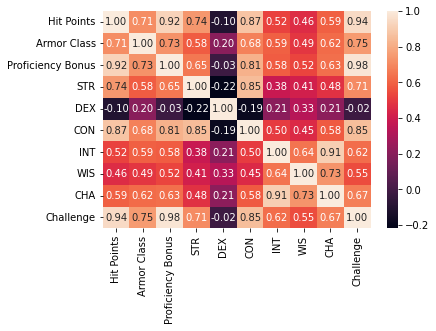

In [ ]:
sns.heatmap(monster_df_numeric.corr(), annot = True, fmt = '.2f');

today i learned that in monsters, dexterity has no correlation to any other numeric stat including challenge rating. The closest thing is wisdom...so sometimes things that are wise are also dexterous which i think is hilarious. 

I don't think we will use Proficiency Bonus moving forward as it is really just linked to CR, so it won't tell us much. Basically, every CR that goes up, the proficiency goes up as well. Just like players levels

In [ ]:
hitpoint_line = sns.relplot(x = "Challenge", y = "Hit Points", kind = "line", data = monster_df_numeric)
armor_line =  sns.relplot(x = "Challenge", y = "Armor Class", kind = "line", data = monster_df_numeric)

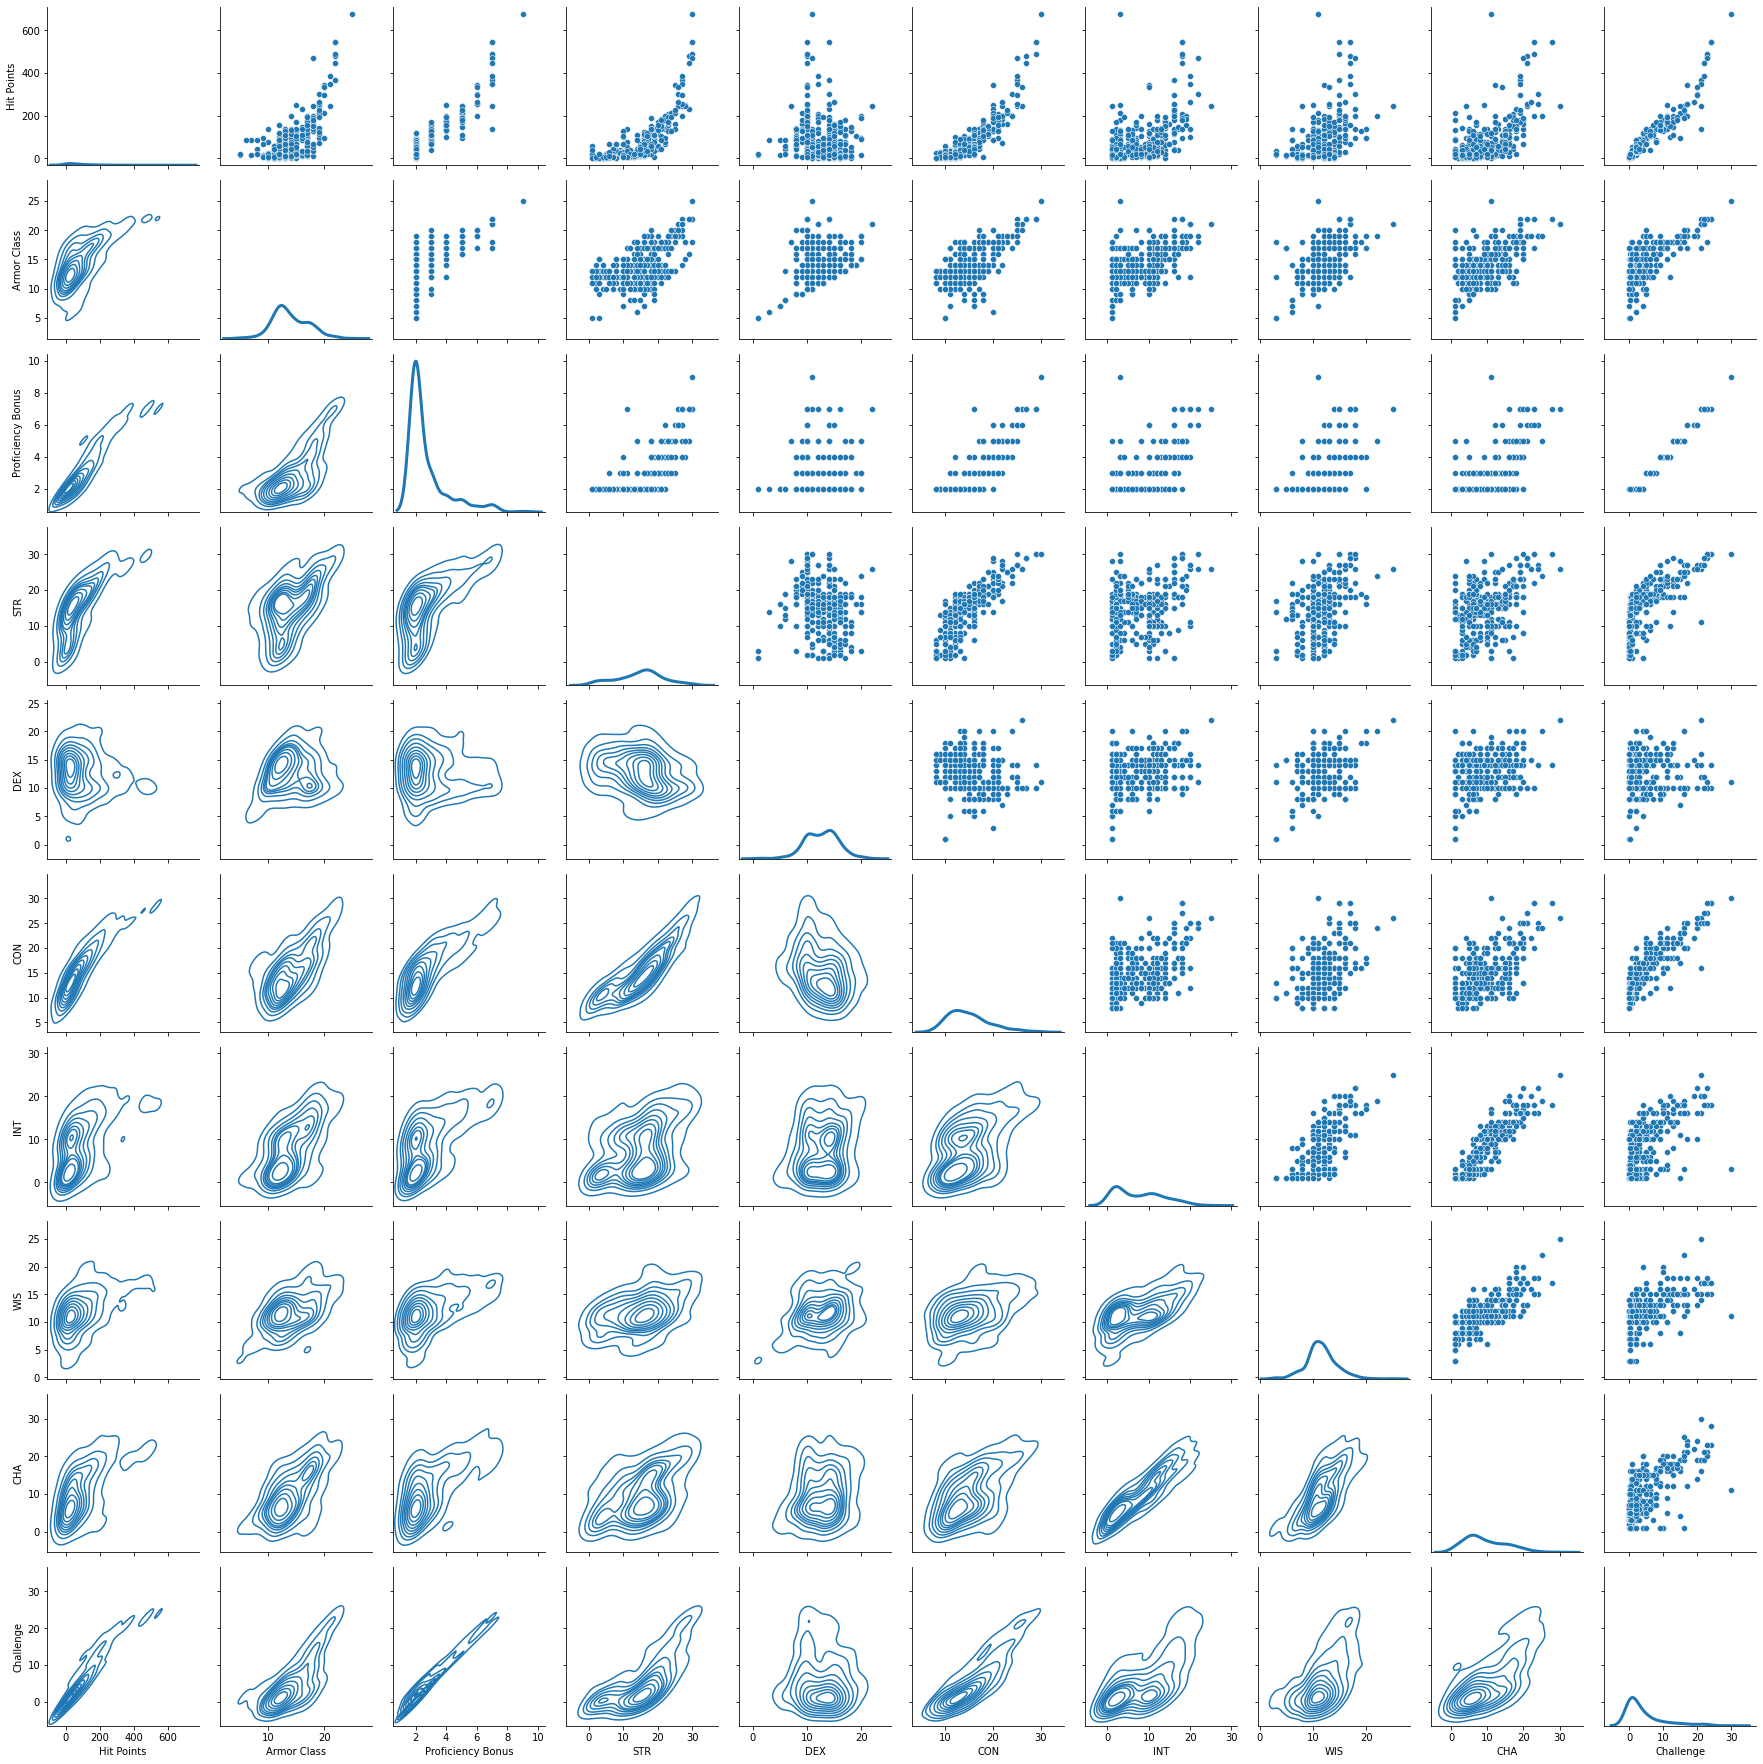

In [ ]:
compare_plots = sns.PairGrid(monster_df_numeric)
compare_plots.map_upper(sns.scatterplot)
compare_plots.map_lower(sns.kdeplot)
compare_plots.map_diag(sns.kdeplot,lw=3,legend=False)

<AxesSubplot:>

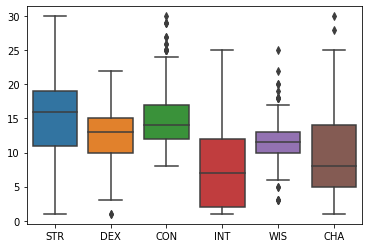

In [ ]:
stats_df = monster_df_numeric.drop(['Hit Points', 'Armor Class', 'Proficiency Bonus', 'Challenge'], axis = 1)
sns.boxplot(data=stats_df)

In [ ]:
stats_df[stats_df['CHA']>25]

,STR,DEX,CON,INT,WIS,CHA
Monster Name,,,,,,
Solar,26,22,26,25,25,30
Ancient Gold Dragon,30,14,29,18,17,28


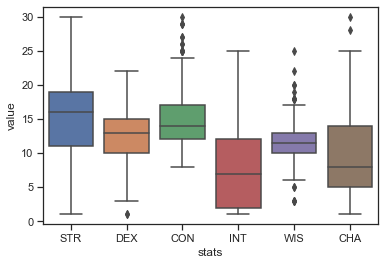

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from bioinfokit.analys import stat

df_melt = pd.melt(stats_df, value_vars=['STR', 'DEX', 'CON', 'INT','WIS','CHA'])

df_melt.columns = ['stats', 'value']

ax = sns.boxplot(x='stats', y='value', data=df_melt);
plt.show();


In [ ]:

model = ols('value ~ C(stats)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(stats),14931.113027,5.0,121.333093,6.702596e-113
Residual,51241.712644,2082.0,NaN,NaN


In [ ]:
res = stat()
res.tukey_hsd(df=df_melt, res_var="value",xfac_var="stats",anova_model="value~C(stats)")
res.tukey_summary

c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\bioinfokit\analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,STR,DEX,2.244253,1.171506,3.317000,8.438980,0.001000
1,STR,CON,0.040230,-1.032517,1.112977,0.151275,0.900000
2,STR,INT,7.267241,6.194494,8.339988,27.326735,0.001000
3,STR,WIS,3.344828,2.272081,4.417575,12.577430,0.001000
4,STR,CHA,5.402299,4.329552,6.475046,20.314062,0.001000
5,DEX,CON,2.284483,1.211736,3.357230,8.590255,0.001000
6,DEX,INT,5.022989,3.950242,6.095735,18.887755,0.001000
7,DEX,WIS,1.100575,0.027828,2.173322,4.138450,0.040513
8,DEX,CHA,3.158046,2.085299,4.230793,11.875082,0.001000
9,CON,INT,7.307471,6.234724,8.380218,27.478010,0.001000


## Looking at Environment, Monster Type, and Tags

In [1]:
monster_df["Type"].value_counts()

NameError: name 'monster_df' is not defined

[Text(0, 0, 'dragon'),
 Text(1, 0, 'elemental'),
 Text(2, 0, 'beast'),
 Text(3, 0, 'humanoid'),
 Text(4, 0, 'ooze'),
 Text(5, 0, 'fey'),
 Text(6, 0, 'fiend'),
 Text(7, 0, 'monstrosity'),
 Text(8, 0, 'celestial'),
 Text(9, 0, 'giant'),
 Text(10, 0, 'undead'),
 Text(11, 0, 'construct'),
 Text(12, 0, 'plant'),
 Text(13, 0, 'aberration'),
 Text(14, 0, 'swarm')]

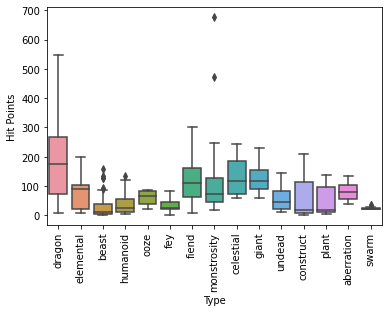

In [ ]:
ax = sns.boxplot(x="Type", y= "Hit Points",data=monster_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [ ]:
monster_stats = monster_df[['Type','Hit Points', 'Armor Class','STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA', 'Challenge']]

In [ ]:
monster_stats = monster_stats.groupby('Type').mean()

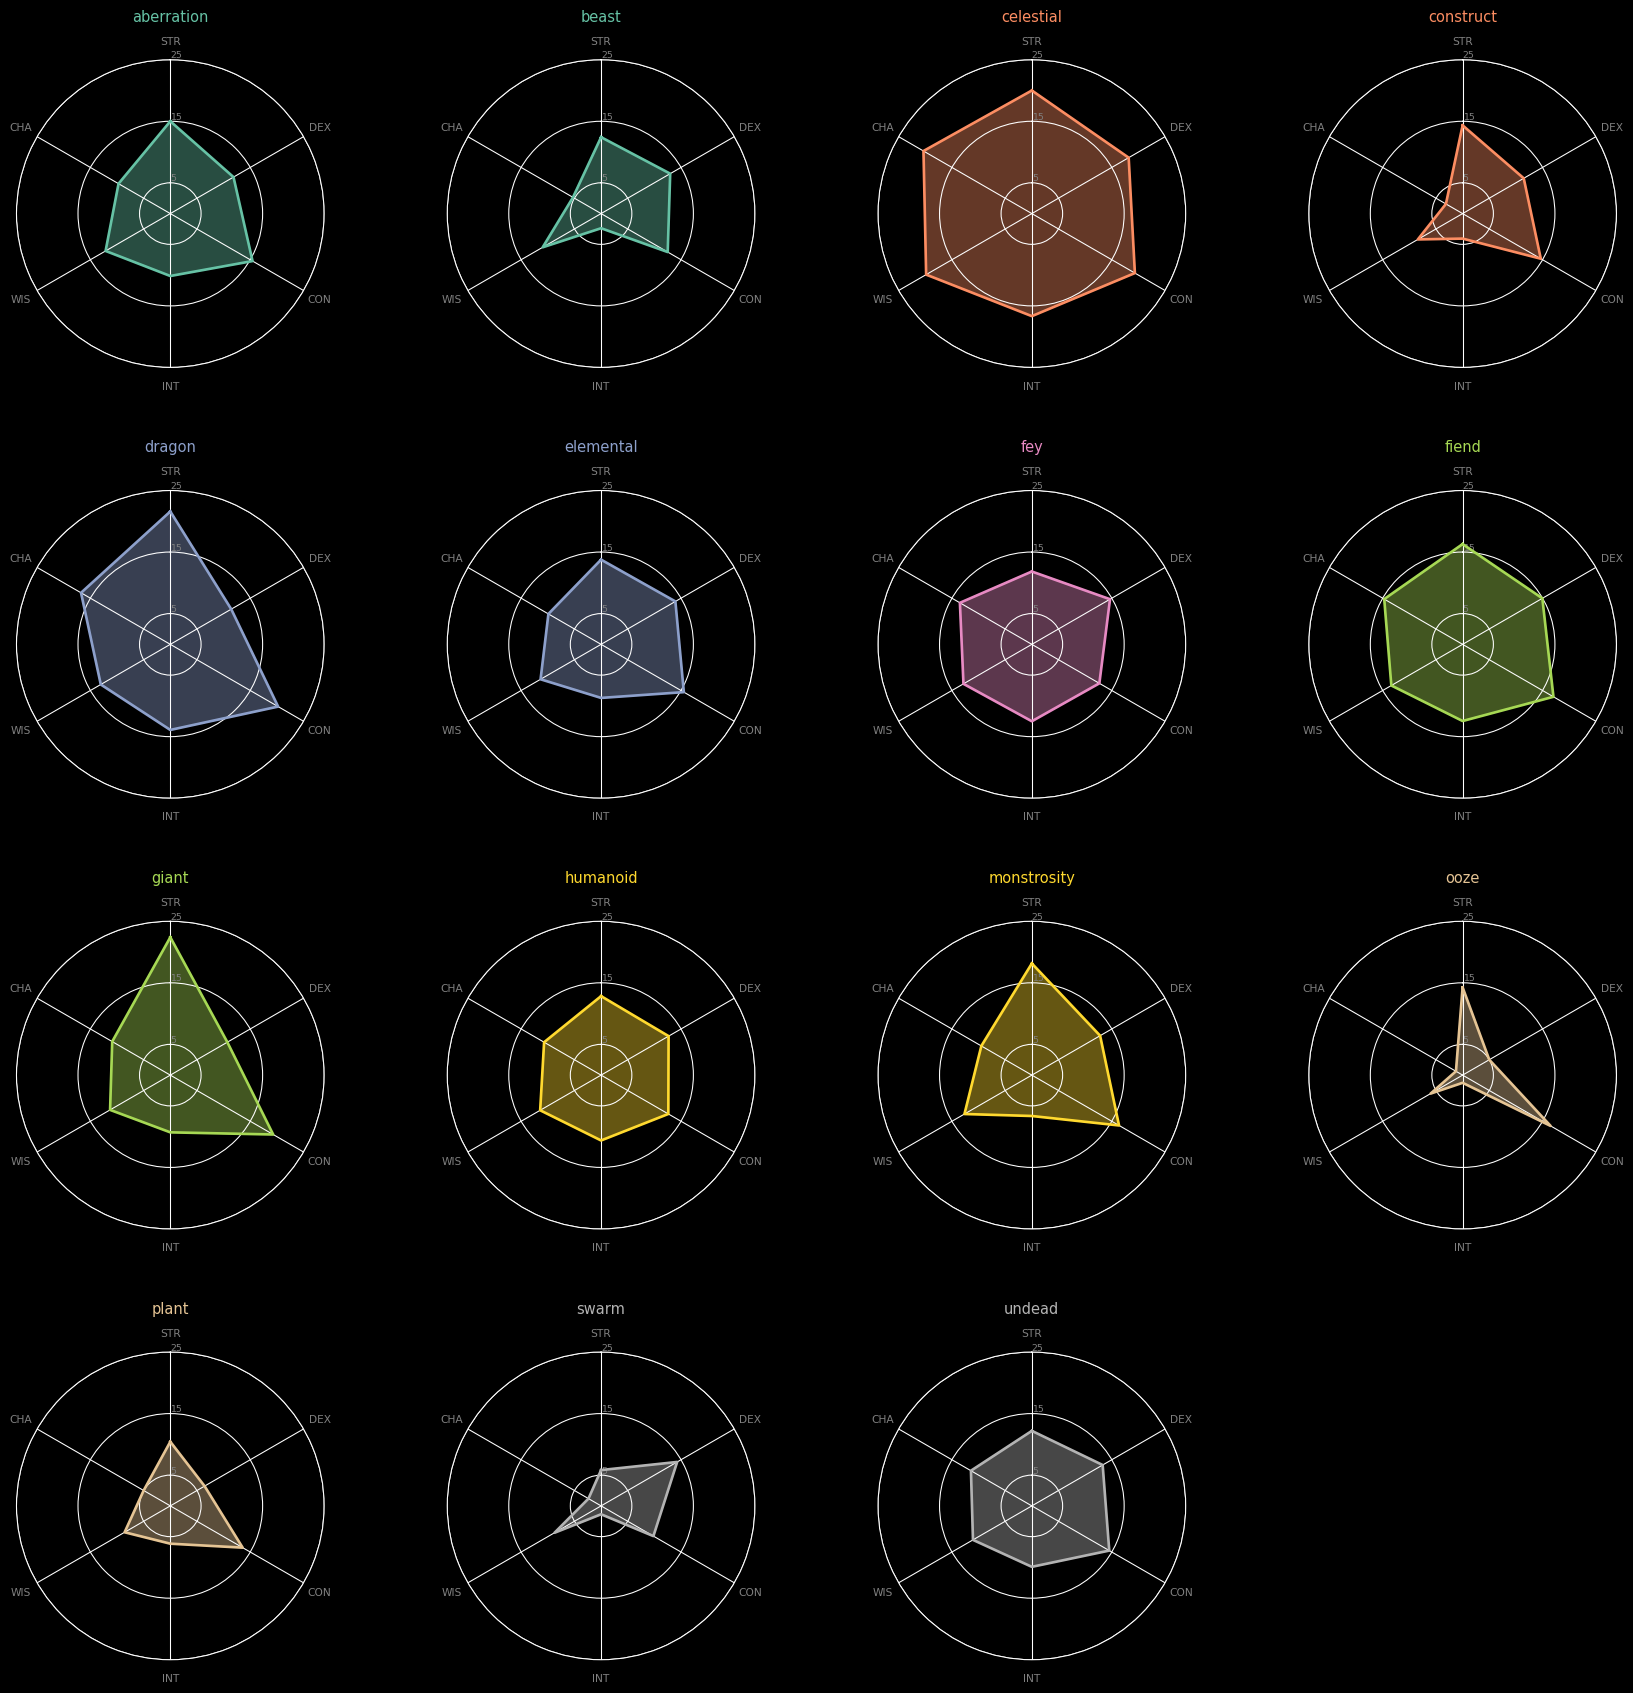

In [ ]:
# Best way to see this is with as radar chart

def make_spider(row, title, color):

    #number of variables
    categories = list(monster_stats)[3:9]
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles+= angles[:1]

    ax = plt.subplot(4,4,row+1, polar = True, )
    plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9,wspace=0.4,hspace=0.4)
    
    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color = "grey", size = 8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([5,15,25], ["5","15","25"], color="grey", size=7)
    plt.ylim(0,30)

    # Ind1
    values=monster_stats.loc[row].drop(labels=['Type','Hit Points','Armor Class','Challenge']).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)
 
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(2000/my_dpi, 2000/my_dpi), dpi=my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(monster_stats.index))

# Loop to plot
for row in range(0, len(monster_stats.index)):
    make_spider(row=row, title=monster_stats['Type'][row], color=my_palette(row))
    


